# Multirun experiment pipeline 0.2.0 (WheatFspm)

The following notebook establishes a generalized pipeline for evaluating a computing reservoir against a given task, given multiple experimental runs of the same reservoir.


In [1]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
sys.path.insert(1, os.path.join(sys.path[0], '../../'))  # for importing local packages from src

In [2]:
DATASET_NEMA_H0 = '../datasets/dataset_NEMA_NEMA_H0.csv'
DATASET_NEMA_H3 = '../datasets/dataset_NEMA_NEMA_H3.csv'
DATASET_NEMA_H15 = '../datasets/dataset_NEMA_NEMA_H15.csv'

### Loading the datasets

These datasets were collected and converted in the WheatFspm repository.

There are three simulations made available in the WheatFspm repository that are useable for RC experiments: NEMA H0, H3 and H15.

We can try using these datasets in two different ways:

1. Treat every dataset as a separate plant, training a readout for each simulation run.
2. Concatenating the three datasets as observed behavior of a single plant.

In [3]:
from src.model.rc_dataset import ExperimentDataset

dataset_nema_h0 = ExperimentDataset(csv_path=DATASET_NEMA_H0)
dataset_nema_h3 = ExperimentDataset(csv_path=DATASET_NEMA_H3)
dataset_nema_h15 = ExperimentDataset(csv_path=DATASET_NEMA_H15)

datasets = [
  ('NEMA_H0', dataset_nema_h0), 
  ('NEMA_H3', dataset_nema_h3), 
  ('NEMA_H15', dataset_nema_h15)
]

### Defining targets and observed state variables

These were selected in a previous notebook, `2022_03_23_wheatfspm_dataset_inspection.ipynb` and are defined in a config file for reuse among notebooks.

In [4]:
%reload_ext autoreload
%autoreload 2 

from model_config import targets, state_variables

print(f'Targets:')
for target in targets:
  print(f'\t- {target}')

print(f'\nState variables:')
for state_var in state_variables:
  print(f'\t- {state_var}')

Targets:
	- input_air_temperature
	- input_humidity
	- input_PARi
	- output__axes__Total_Transpiration
	- output__axes__C_exudated
	- output__axes__SAM_temperature
	- output__axes__delta_teq
	- output__axes__sum_respi_shoot
	- output__organ_roots__N_exudation

State variables:
	- state__An
	- state__Transpiration
	- state__S_Sucrose
	- state__Ts
	- state__gs
	- state__Ag
	- state__Tr
	- state__sucrose
	- state__Rd
	- state__sum_respi
	- state__Photosynthesis
	- state__PARa


### Data preprocessing, grouping and train-test splitting

The available datasets will be processed into 4 datasets:

- NEMA_H0
- NEMA_H3
- NEMA_H15
- NEMA_COMBINED (concatenated as data from the same plant)

In [5]:
from src.learning.preprocessing import generate_mask


WARMUP_STEPS = 4 * 24
DAY_MASK = generate_mask(5, 21)

### Model definition

- Readout model is a standard RidgeRegression model with intercept term and CV-tuned regularization strength $\alpha$.
- CV search grid is a progression of logarithmicly spaced values for regularization strength $\alpha$.
- CV and testing metric is NMSE.

In [8]:
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline

from src.learning.scorers import nmse_scorer

readout = Pipeline([
  ('ridge_regression', Ridge(alpha=1, fit_intercept=True))
])

search_grid = [{
  'ridge_regression__alpha': 10 ** np.linspace(np.log10(1e-4), np.log10(1e2), 50)
}]

scorer = nmse_scorer

### Generating a manifest of all experiments to run

Currently we are only benchmarking direct target prediction, but in the future there will be other tasks generated from the base targets as well. These will be generated in this section.


In [23]:
# Ratio of training to testing samples (in groups of 16 samples belonging to the same day)
TRAIN_TEST_RATIO = 1

# Amount of consecutive groups that are taken as training or testing groups.
# e.g. for BLOCKS=4, the split is 1111 0000 1111 0000 ...
BLOCKS = 4

We will test different cross-validation folding strategies:

In [10]:
from sklearn.model_selection import GroupKFold


STRATEGIES = [
  # {
  #   'strat_name': '3_folds',
  #   'fold_generator': lambda groups : GroupKFold(n_splits=3)
  # },
  # {
  #   'strat_name': '4_folds',
  #   'fold_generator': lambda groups : GroupKFold(n_splits=4)
  # },
  # {
  #   'strat_name': '5_folds',
  #   'fold_generator': lambda groups : GroupKFold(n_splits=5)
  # },
  {
    'strat_name': 'LeaveOneOut',
    'fold_generator': lambda groups : GroupKFold(n_splits=np.unique(groups).shape[0])
  },
]

### Fitting all readout functions

Process:
- for each fitting strategy:
  - For each target:
    - For each observed state variable:
      - For each dataset:
        1. Preprocess the data
        2. Fit for each dataset
        3. Store the resulting training, cross-validation and test scores.

In [39]:
from dataclasses import dataclass
from sklearn.model_selection import BaseCrossValidator


@dataclass
class ModelFitParams:
  """Class definining a model to be fitted."""
  X_name: str
  y_name: str
  dataset_name: str
  X: np.ndarray
  y: np.ndarray
  groups: np.ndarray
  folds: BaseCrossValidator
  note: str = ''

In [52]:
from sklearn.base import clone as clone_model, BaseEstimator

from src.learning.training import perform_gridsearch
from wheatfspm_pipeline_utils import train_test_split_alternating


def fit_test_model(model: BaseEstimator, search_grid: dict, params: ModelFitParams):
  """TODO: write desc"""
  train, test = train_test_split_alternating(params.X, params.y, params.groups, ratio=1, blocks=4)

  # search optimal model params
  X_train, y_train, groups_train = train
  cv_model, scores = perform_gridsearch(model, X_train, y_train, groups_train, params.folds, search_grid, verbose=False)
  (train_mean, train_std), (cv_mean, cv_std) = scores

  # fit with optimal params using all training data
  final_model = clone_model(model)
  final_model.set_params(**cv_model.best_params_)
  final_model.fit(X_train, y_train)

  # Determine test scores
  X_test, y_test, _ = test
  test_score = scorer(final_model, X_test, y_test)
  result_dict = {
      'target': params.y_name,
      'state_var': params.X_name,
      'dataset': params.dataset_name,
      'note': params.note,
      'test_score': test_score,
      'train_mean': train_mean,
      'train_std': train_std,
      'cv_mean': cv_mean,
      'cv_std': cv_std,
  }

  return (final_model, result_dict)

In [113]:
%reload_ext autoreload
%autoreload 2 
from wheatfspm_pipeline_utils import generate_X_y_groups, generate_X_y_groups_baseline, direct_target_generator, direct_reservoir_generator
from sklearn.model_selection import LeaveOneGroupOut


def generate_ModelFitParams_fpsm_reservoir(*, datasets, target_state_pairs, target_generator, state_generator, 
                                          folds, warmup_steps, day_mask, combined_only=True, note=''):
  params_list = []

  for target, state_var in target_state_pairs:
    preprocessed_data = generate_X_y_groups(
      datasets=datasets, 
      target=target, 
      state_var=state_var,
      target_generator=direct_target_generator, 
      state_generator=direct_reservoir_generator,
      warmup_steps=warmup_steps, 
      day_mask=day_mask,
      combined_only=combined_only,
    )

    for name, (X, y, groups) in preprocessed_data.items():
      params = ModelFitParams(
        X_name=state_var,
        y_name=target,
        dataset_name=name,
        X=X,
        y=y,
        groups=groups,
        folds=folds,
        note=note
      )
      params_list.append(params)

  return params_list


def generate_ModelFitParams_baseline_reservoir(*, datasets, target_env_pairs, target_generator, folds,
                                               warmup_steps, day_mask, combined_only=True, note=''):
  params_list = []

  # for target in targets:
  for target, (env_name, env_targets) in target_env_pairs:
    preprocessed_data = generate_X_y_groups_baseline(
      datasets=datasets,
      target=target,
      env_targets=env_targets,
      prefix=env_name,
      target_generator=target_generator,
      warmup_steps=warmup_steps,
      day_mask=day_mask,
      combined_only=combined_only,
    )

    for name, (X, y, groups) in preprocessed_data.items():
      params = ModelFitParams(
        X_name=env_name,
        y_name=target,
        dataset_name=f'{name}_{env_name}',
        X=X,
        y=y,
        groups=groups,
        folds=folds,
        note=note
      )
      params_list.append(params)

  return params_list

---

In [114]:
from model_config import baseline_reservoirs


target_state_pairs = [(target, state_var) for target in targets for state_var in state_variables]

model_fit_params_fspm = generate_ModelFitParams_fpsm_reservoir(
  datasets=datasets,
  target_state_pairs=target_state_pairs,
  target_generator=direct_target_generator,
  state_generator=direct_reservoir_generator,
  folds=LeaveOneGroupOut(),
  warmup_steps=WARMUP_STEPS, 
  day_mask=DAY_MASK
)

target_env_pairs = [(target, baseline_res) for target in targets for baseline_res in baseline_reservoirs]

model_fit_params_env = generate_ModelFitParams_baseline_reservoir(
  datasets=datasets,
  target_env_pairs=target_env_pairs,
  target_generator=direct_target_generator,
  folds=LeaveOneGroupOut(),
  warmup_steps=WARMUP_STEPS,
  day_mask=DAY_MASK
)

In [115]:
from tqdm import tqdm
from src.learning.training import perform_gridsearch
from wheatfspm_pipeline_utils import train_test_split_alternating


MODEL_FIT_PARAMS = model_fit_params_fspm + model_fit_params_env
RESULTS_FILE = 'results.csv'


total_loops = len(MODEL_FIT_PARAMS)
print(f'Performing {total_loops} fits...')

models = []
results = []

with tqdm(total=total_loops) as pbar:
    for params in MODEL_FIT_PARAMS:
        model, result_dict = fit_test_model(readout, search_grid, params)
        models.append(model)
        results.append(result_dict)
        pbar.update(1)

    results_df = pd.DataFrame.from_dict(results)
    results_df.to_csv(RESULTS_FILE)
    print(f'Saved scores to {RESULTS_FILE}')

Performing 126 fits...


100%|██████████| 126/126 [00:45<00:00,  2.77it/s]

Saved scores to results.csv


In [112]:
results_df.tail()

,target,state_var,dataset,note,test_score,train_mean,train_std,cv_mean,cv_std
121,env_temp_only,state__PARa,combined_env_temp_only,,-0.091125,-0.065177,0.003838,-0.201610,0.096609
122,env_res,state__PARa,combined_env_res,,-0.895594,-0.702378,0.036388,-17.786501,18.012554
123,env_temp_only,state__PARa,combined_env_temp_only,,-0.833630,-0.718750,0.032042,-17.208637,18.498425
124,env_res,state__PARa,combined_env_res,,-1.650313,-0.882181,0.023425,-3.091314,3.576003
125,env_temp_only,state__PARa,combined_env_temp_only,,-1.699110,-0.892320,0.023459,-2.896739,3.315947


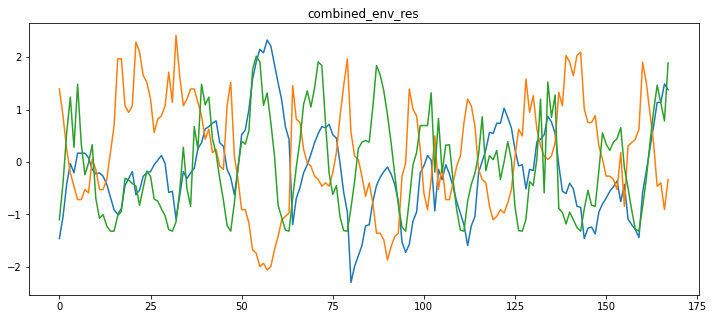

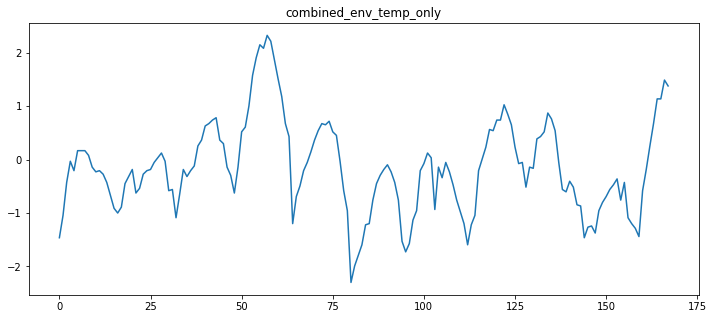

In [111]:
model_fit_params_env

plt.figure(figsize=(12,5))
plt.plot(model_fit_params_env[0].X[:7*24])
plt.title(f'{model_fit_params_env[0].dataset_name}')
plt.show()

plt.figure(figsize=(12,5))
plt.plot(model_fit_params_env[1].X[:7*24])
plt.title(f'{model_fit_params_env[1].dataset_name}')
plt.show()
